# Assigment 2 - Forecasting Electricity Prices

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import pipeline, arima, model_selection
from math import sqrt
import warnings
import numpy as np
import os
import pandas as pd
import datetime as dt

warnings.filterwarnings("ignore")

Loading in required data, and filtering according to requirements.

In [97]:
file_P = os.path.join(os.getcwd(),'data/Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

## Task 1
Develop an ARIMA model to predict electricity prices. Your goal in all following tasks is to achieve the best possible performance. In both sub-tasks report the RMSE values you achieve with your models.


### 1.1 
Use NO exogenous variables in your model and make day-ahead prediction for your testing dataset. You can use a seasonal ARIMA or FourierFeaturizer and any data transformation you want in your model, but no exogenous features from df data. Establish a suitable persistence forecast and report the RMSE values in both cases (your model and  persistence). Briefly discuss your results.

We start by dividing the data into training- and test sets.

In [98]:
# We use the time intervial.
t_s_data = pd.Timestamp(dt.datetime(2019, 1, 1, 0, 0, 0))
t_e_data = pd.Timestamp(dt.datetime(2023, 8, 31, 23, 0, 0))

data_all = df_prices.loc[(df_prices['HourUTC'] >= t_s_data) & (df_prices['HourUTC'] <= t_e_data)]
data_all = data_all.reset_index(drop=True)

# We use the time intervial.
t_s_train = pd.Timestamp(dt.datetime(2023, 9, 1, 0, 0, 0))
t_e_train = pd.Timestamp(dt.datetime(2023, 11, 30, 23, 0, 0))

train = df_prices.loc[(df_prices['HourUTC'] >= t_s_train) & (df_prices['HourUTC'] <= t_e_train)]
train = train.reset_index(drop=True)

t_s_test = pd.Timestamp(dt.datetime(2023, 12, 1, 0, 0, 0))
t_e_test= pd.Timestamp(dt.datetime(2023, 12, 31, 23, 0, 0))

test = df_prices.loc[(df_prices['HourUTC'] >= t_s_test) & (df_prices['HourUTC'] <= t_e_test)]
test = test.reset_index(drop=True)

We will plot the two sets besides each other

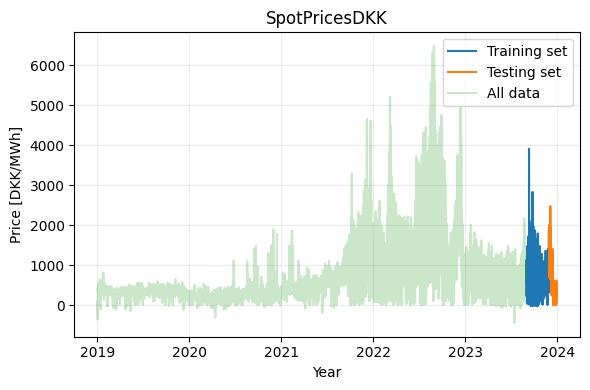

In [99]:

plt.figure(figsize=(6, 4), dpi=100)

plt.plot(train['HourUTC'], train['SpotPriceDKK'])
plt.plot(test['HourUTC'], test['SpotPriceDKK'])
plt.plot(data_all['HourUTC'], data_all['SpotPriceDKK'], alpha=0.25)


plt.title('SpotPricesDKK')
plt.xlabel('Year')
plt.ylabel('Price [DKK/MWh]')

plt.legend(["Training set", "Testing set" , "All data"])
plt.tight_layout()
plt.grid(alpha=0.25)
plt.show()

We will use a method that automatically fits the best model for us. We will first remove all the columns other than the numericals values for SpotPricesDKK.

In [100]:
train_Arima = train['SpotPriceDKK']
test_Arima = test['SpotPriceDKK']

# Automatically fit the ARIMA model
# model = pm.auto_arima(train_Arima, seasonal = True, trace = True, maxiter = 10, stepwise = True, method = 'nm', m = 24)
model = pm.arima.ARIMA(order=(1,1,5), seasonal_order=(2,0,2,24)) #(2,0,2)
model.fit(train_Arima)

# Here the optimal model was found through auto_arima(), but later fit manually to save time during testing

ARIMA(order=(1, 1, 5), seasonal_order=(2, 0, 2, 24))

In [101]:
# Day-ahead prediction
pred = []

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values for all time series at once
    pred_temp = model.predict(24)
    pred.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24])

For comparison, a simple persistence model is created.

In [102]:
pers = np.zeros(len(test_Arima)).tolist()

for i in range(24, len(test_Arima), 24):
    for j in range(24):
        pers[i+j] = test_Arima[(i-24)+j]

The test data is plotted along with the ARIMA predictions and the persistence model.

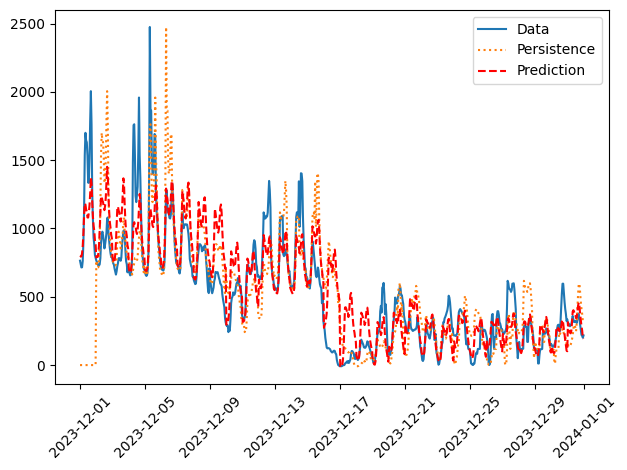

In [103]:
plt.figure()
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pers, label='Persistence', linestyle="dotted")
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The error metrics for both are calculated.

In [104]:
# Calculate error metrics
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred))
MAE_AR_pred = mean_absolute_error(test_Arima, pred)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

print('')

RMSE_AR_pers = sqrt(mean_squared_error(test_Arima, pers))
MAE_AR_pers = mean_absolute_error(test_Arima, pers)
print('Persistence')
print('\t Root-mean-square error: ', round(RMSE_AR_pers,2))
print('\t Mean absolute error: ', round(MAE_AR_pers,2))

Prediction
	 Root-mean-square error:  223.96
	 Mean absolute error:  156.14

Persistence
	 Root-mean-square error:  339.24
	 Mean absolute error:  214.76


This shows that the day-ahead prediction with no exogenous variables is only slightly better than simply assuming the same values as the previous day.

### 1.2
Add any exogenous variables you want (maximum 3) and repeat the process (choose/optimize
your model and evaluate it for the day-ahead prediction). What exogenous variables helped you improve the prediction and how did you choose the specific ones? Report the RMSE value and compare your results with those from task 1.1 and briefly discuss them.

Loading in the data with exogenous variables.

In [105]:
file_P = os.path.join(os.getcwd(),'data/ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.loc[df_data["PriceArea"].isin(["DK2"])]
df_data = df_data.reset_index(drop=True)

In [106]:
# Which variables do we have to choose from?
for col in df_data.columns:
    print(col)

HourUTC
HourDK
PriceArea
CentralPowerMWh
LocalPowerMWh
CommercialPowerMWh
LocalPowerSelfConMWh
OffshoreWindLt100MW_MWh
OffshoreWindGe100MW_MWh
OnshoreWindLt50kW_MWh
OnshoreWindGe50kW_MWh
HydroPowerMWh
SolarPowerLt10kW_MWh
SolarPowerGe10Lt40kW_MWh
SolarPowerGe40kW_MWh
SolarPowerSelfConMWh
UnknownProdMWh
ExchangeNO_MWh
ExchangeSE_MWh
ExchangeGE_MWh
ExchangeNL_MWh
ExchangeGB_MWh
ExchangeGreatBelt_MWh
GrossConsumptionMWh
GridLossTransmissionMWh
GridLossInterconnectorsMWh
GridLossDistributionMWh
PowerToHeatMWh


In [107]:
'''
for i in range(5,8):
    train.insert(i, df_data.columns[i+1], df_data[df_data.columns[i+1]])

'''

train.insert(2, 'ExchangeSE_MWh', df_data['ExchangeSE_MWh'])
train.insert(3, 'GrossConsumptionMWh', df_data['GrossConsumptionMWh'])
# train.insert(4, 'OffshoreWindGe100MW_MWh', df_data['OffshoreWindGe100MW_MWh'])

train = train.drop(columns=['HourUTC', 'SpotPriceDKK'])
train = train.dropna(axis=1)


for col in train.columns:
    print(col)

ExchangeSE_MWh
GrossConsumptionMWh


In [108]:
# exog = pd.DataFrame(train[['Exchange_SE', 'GrossConsumptionMWh', 'Offshore_Gen']])

X_train_ar = np.column_stack([np.arange(1, len(train_Arima)+1), train_Arima])

model.fit(train_Arima, X = X_train_ar)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2184
Model:             SARIMAX(1, 1, 5)x(2, 0, [1, 2], 24)   Log Likelihood               23113.421
Date:                                 Sun, 14 Apr 2024   AIC                         -46198.843
Time:                                         18:50:19   BIC                         -46119.204
Sample:                                              0   HQIC                        -46169.731
                                                - 2184                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.58e-14      7e-21   2.26e+06      0.000    1.58e-14    1.58e-14
x1         -1.048e-14   2.66e-22  -3.94e+07      0.000   -1.05e-14   -1.05e-14
x2             1.0000   1.83e-20   5.46e+19      0.000       1.000       1.000
ar.L1          0.6858   1.29e-23    5.3e+22      0.000       0.686       0.686
ma.L1         -0.4203   1.48e-23  -2.85e+22      0.000      -0.420      -0.420
ma.L2         -0.2889   7.29e-23  -3.96e+21      0.000      -0.289      -0.289
ma.L3         -0.1005   7.41e-23  -1.36e+21      0.000      -0.100      -0.100
ma.L4         -0.0711   7.49e-23   -9.5e+20      0.000      -0.071      -0.071
ma.L5          0.0230   6.16e-23   3.73e+20      0.000       0.023       0.023
ar.S.L24       0.4693   1.43e-21   3.28e+20      0.000       0.469       0.469
ar.S.L48       0.3920   1.42e-21   2.77e+20      0.000       0.392       0.392
ma.S.L24      -0.2858   6.75e-22  -4.23e+20      0.000      -0.286      -0.286
ma.S.L48      -0.3950    6.6e-22  -5.99e+20      0.000      -0.395      -0.395
sigma2          1e-10   4.24e-11      2.357      0.018    1.68e-11    1.83e-10
===================================================================================
Ljung-Box (L1) (Q):                  13.60   Jarque-Bera (JB):             19465.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.31
Prob(H) (two-sided):                  0.09   Kurtosis:                        17.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.71e+55. Standard errors may be unstable.
"""

KØR DETTE NEDENFOR, JEG TROR train[] og X_f[] HAR DE RIGTIGE FORMATER (LÆS OPGAVEBESKRIVELSEN), SÅ JEG TROR PREDICT() VIL VIRKE NU

In [91]:
# Day-ahead prediction
pred_exog = []
X_f = train[:24]

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values for all time series at once
    pred_temp = model.predict(24, X_f)
    pred_exog.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24], X_f)

Now we can plot it

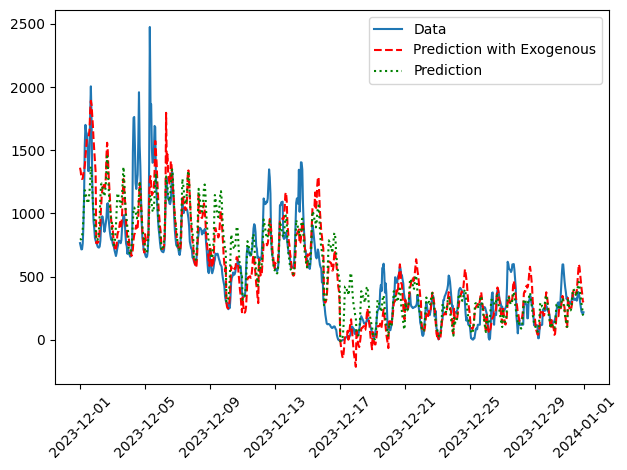

In [109]:
plt.figure()
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pred_exog, label='Prediction with Exogenous', linestyle="dashed", color="red")
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dotted", color="green")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
# Calculate error metrics
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred_exog))
MAE_AR_pred = mean_absolute_error(test_Arima, pred_exog)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))


Prediction
	 Root-mean-square error:  221.11
	 Mean absolute error:  158.8


LAVER MODEL MED SARIMAX

In [31]:
# Create and fit the SARIMAX model
model = SARIMAX(train_Arima, exog=pred_exog, order=(1,1,5), seasonal_order=(2,0,2,24))
model_fit = model.fit(disp=False)  # 'disp=False' to turn off diagnostic output

# Display the summary of the model
print(model_fit.summary())

ValueError: endog and exog matrices are different sizes

In [ ]:
test.insert(2, "Exchange_SE", df_data["ExchangeSE_MWh"])
test.insert(3, "GrossConsumptionMWh", df_data["GrossConsumptionMWh"])
test.insert(4, "Offshore_Gen", df_data["OffshoreWindGe100MW_MWh"])

In [ ]:
test_Arima = test['SpotPriceDKK']  # Replace 'SpotPriceDKK' with your dependent variable
exog_test = test[['Exchange_SE', 'GrossConsumptionMWh', 'Offshore_Gen']]

# Forecast using the SARIMAX model
forecasts = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test)



Calculate RMSE

In [ ]:

rmse = np.sqrt(mean_squared_error(test_Arima, forecasts))
print("RMSE for model with exogenous variables:", rmse)

In [ ]:
model_fourier = pm.preprocessing.FourierFeaturizer(m=24, k = 12)

model_fourier_fit = model_fourier.fit(train, X = exog)

In [ ]:
train, test = model_selection.train_test_split(train["SpotPriceDKK"], train_size=2184)

train, test = model_selection.train_test_split(train["SpotPriceDKK"], train_size=2184)
X_train, X_test = model_selection.train_test_split(train[["OffshoreWindGe100MW_MWh","ExchangeSE_MWh","GridLossDistributionMWh"]], train_size=2184)

X_train_ar = np.column_stack([np.arange(1, n+1), X_train])